In [1]:
import sys, os
sys.path.insert(0, '../../../residual2vec_')

In [2]:
os.environ['DISABLE_WANDB'] = 'true'

#disable epoch level tqdm
os.environ['DISABLE_TQDM'] = 'true'

In [3]:
# standard imports
import numpy as np
import pandas as pd
import pickle as pkl
from scipy import sparse
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
# codebase
from utils import snakemake_utils, score


/data/sg/ashutiwa/miniconda3/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using GPU: cuda:0


In [5]:

DIR = '../../../final_'
def get_embs(dataset, directory, root=DIR):
    model_to_embs = {
    "fairwalk+deepwalk": "{}/{}_fairwalk_deepwalk.npy",
    "fairwalk+node2vec": "{}/{}_fairwalk_node2vec.npy",
    "crosswalk+deepwalk": "{}/{}_crosswalk_deepwalk.npy",
    "crosswalk+node2vec": "{}/{}_crosswalk_node2vec.npy",
    "GCN+deepwalk+random": "{}/{}_gcn_deepwalk_deepwalk_embs.npy",
    "GCN+deepwalk+r2v": "{}/{}_gcn_deepwalk_r2v_embs.npy",
    "GCN+node2vec+random": "{}/{}_gcn_node2vec_deepwalk_embs.npy",
    "GCN+node2vec+r2v": "{}/{}_gcn_node2vec_r2v_embs.npy",
    "GAT+deepwalk+random": "{}/{}_gat_deepwalk_deepwalk_embs.npy",
    "GAT+deepwalk+r2v": "{}/{}_gat_deepwalk_r2v_embs.npy",
    "GAT+node2vec+random": "{}/{}_gat_node2vec_deepwalk_embs.npy",
    "GAT+node2vec+r2v": "{}/{}_gat_node2vec_r2v_embs.npy",
    "deepwalk": "{}/{}_deepwalk.npy",
    "node2vec": "{}/{}_node2vec.npy",
    "residual2vec": "{}/{}_residual2vec_embs.npy",
    "baseline+deepwalk": "{}/{}_baseline_man_woman+deepwalk_embs.npy",
    "baseline+node2vec": "{}/{}_baseline_man_woman+node2vec_embs.npy",}
    
    folder = root + '/' + dataset + '/' + dataset + '_' + directory
    ret = {}
    for i in model_to_embs:
        ret[i] = np.load(model_to_embs[i].format(folder, dataset))
        
        
    return ret



In [6]:
embs_airport = get_embs('airport', 'five')



embs_polblog = get_embs('polblog', 'one')
embs_polbook = get_embs('polbook', 'one')
embs_pokec = get_embs('twitch', 'one')

embs_fb = get_embs('facebook', 'one')

y_airport = snakemake_utils.get_dataset("airport").get_grouped_col()
N_airport = y_airport.shape[0]
y_pokec = snakemake_utils.get_dataset("twitch").get_grouped_col()
N_pokec = y_pokec.shape[0]
y_polblog = snakemake_utils.get_dataset("polblog").get_grouped_col()
N_polblog = y_polblog.shape[0]
y_polbook = snakemake_utils.get_dataset("polbook").get_grouped_col()
N_polbook = y_polbook.shape[0]
y_fb = snakemake_utils.get_dataset("facebook").get_grouped_col()
N_fb = y_fb.shape[0]



# g = sns.FacetGrid(data=df, col="model", hue="model", row="dataset")
# g.map(sns.displot, x="scores")

Extracting /tmp/large_twitch_edges.csv.zip
Extracting /tmp/large_twitch_features.csv.zip
Using existing file polbooks.gml


In [7]:
df = []
df.append(pd.DataFrame({
    'disparity per node': np.concatenate(
        (
            
            score.get_node_parity(embs_polbook["GAT+deepwalk+random"], y_polbook, 'std'),
            score.get_node_parity(embs_polbook["GAT+deepwalk+r2v"], y_polbook, 'std'),
            score.get_node_parity(embs_polblog["GAT+deepwalk+random"], y_polblog, 'std'),
            score.get_node_parity(embs_polblog["GAT+deepwalk+r2v"], y_polblog, 'std'),
            score.get_node_parity(embs_airport["GAT+deepwalk+random"], y_airport, 'std'),
            score.get_node_parity(embs_airport["GAT+deepwalk+r2v"], y_airport, 'std'),
            score.get_node_parity(embs_pokec["GAT+deepwalk+random"], y_pokec, 'std'),
            score.get_node_parity(embs_pokec["GAT+deepwalk+r2v"], y_pokec, 'std'),
            score.get_node_parity(embs_fb["GAT+deepwalk+random"], y_fb, 'std'),
            score.get_node_parity(embs_fb["GAT+deepwalk+r2v"], y_fb, 'std'),
        )
    ),
    'model': np.array(['baseline'] * N_polbook + ['proposed'] * N_polbook + 
                      ['baseline'] * N_polblog + ['proposed'] * N_polblog + 
                      ['baseline'] * N_airport + ['proposed'] * N_airport 
                      +['baseline'] * N_pokec + ['proposed'] * N_pokec 
                      +['baseline'] * N_fb + ['proposed'] * N_fb
                     ),
    'dataset': np.array(
                       ['polbook'] * 2 * N_polbook +
                       ['polblog'] * 2 * N_polblog +
                    ['airport'] * 2 * N_airport
        +['twitch'] * 2 * N_pokec
        +['facebook'] * 2 * N_fb
    ),
    'architecture': ['gat'] * 2 * (N_polbook+ N_polblog+ N_airport+N_pokec+N_fb)
    
})
      )
df.append(
    pd.DataFrame({
    'disparity per node': np.concatenate(
        (
            
            score.get_node_parity(embs_polbook["GCN+deepwalk+random"], y_polbook, 'std'),
            score.get_node_parity(embs_polbook["GCN+deepwalk+r2v"], y_polbook, 'std'),
            score.get_node_parity(embs_polblog["GCN+deepwalk+random"], y_polblog, 'std'),
            score.get_node_parity(embs_polblog["GCN+deepwalk+r2v"], y_polblog, 'std'),
            score.get_node_parity(embs_airport["GCN+deepwalk+random"], y_airport, 'std'),
            score.get_node_parity(embs_airport["GCN+deepwalk+r2v"], y_airport, 'std'),
            score.get_node_parity(embs_pokec["GCN+deepwalk+random"], y_pokec, 'std'),
            score.get_node_parity(embs_pokec["GCN+deepwalk+r2v"], y_pokec, 'std'),
            score.get_node_parity(embs_fb["GCN+deepwalk+random"], y_fb, 'std'),
            score.get_node_parity(embs_fb["GCN+deepwalk+r2v"], y_fb, 'std'),
        )
    ),
    'model': np.array(['baseline'] * N_polbook + ['proposed'] * N_polbook + 
                      ['baseline'] * N_polblog + ['proposed'] * N_polblog + 
                      ['baseline'] * N_airport + ['proposed'] * N_airport 
                      +['baseline'] * N_pokec + ['proposed'] * N_pokec 
                      +['baseline'] * N_fb + ['proposed'] * N_fb
                     ),
    'dataset': np.array(
                       ['polbook'] * 2 * N_polbook +
                       ['polblog'] * 2 * N_polblog +
                    ['airport'] * 2 * N_airport
        +['twitch'] * 2 * N_pokec
        +['facebook'] * 2 * N_fb
    ),
    'architecture': ['gcn'] * 2 * (N_polbook+ N_polblog+ N_airport+N_pokec+N_fb)
        
    
})
    )

df.append(
    pd.DataFrame({
    'disparity per node': np.concatenate(
        (
            
            score.get_node_parity(embs_polbook["deepwalk"], y_polbook, 'std'),
            score.get_node_parity(embs_polbook["residual2vec"], y_polbook, 'std'),
            score.get_node_parity(embs_polblog["deepwalk"], y_polblog, 'std'),
            score.get_node_parity(embs_polblog["residual2vec"], y_polblog, 'std'),
            score.get_node_parity(embs_airport["deepwalk"], y_airport, 'std'),
            score.get_node_parity(embs_airport["residual2vec"], y_airport, 'std'),
            score.get_node_parity(embs_pokec["deepwalk"], y_pokec, 'std'),
            score.get_node_parity(embs_pokec["residual2vec"], y_pokec, 'std'),
            score.get_node_parity(embs_fb["deepwalk"], y_fb, 'std'),
            score.get_node_parity(embs_fb["residual2vec"], y_fb, 'std'),
        )
    ),
    'model': np.array(['baseline'] * N_polbook + ['proposed'] * N_polbook + 
                      ['baseline'] * N_polblog + ['proposed'] * N_polblog + 
                      ['baseline'] * N_airport + ['proposed'] * N_airport 
                      +['baseline'] * N_pokec + ['proposed'] * N_pokec 
                      +['baseline'] * N_fb + ['proposed'] * N_fb
                     ),
    'dataset': np.array(
                       ['polbook'] * 2 * N_polbook +
                       ['polblog'] * 2 * N_polblog +
                    ['airport'] * 2 * N_airport
        +['twitch'] * 2 * N_pokec
        +['facebook'] * 2 * N_fb
    ),
    'architecture': ['word2vec'] * 2 * (N_polbook+ N_polblog+ N_airport+N_pokec+N_fb)
    
    
    
})
)
df = pd.concat(df, axis=0, ignore_index=True)

df.shape


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 41554/41554 [00:06<00:00, 6131.93it/s]


(1283370, 4)

In [8]:
df.head()

,disparity per node,model,dataset,architecture
0,0.470224,baseline,polbook,gat
1,0.484261,baseline,polbook,gat
2,0.486042,baseline,polbook,gat
3,0.438122,baseline,polbook,gat
4,0.430713,baseline,polbook,gat


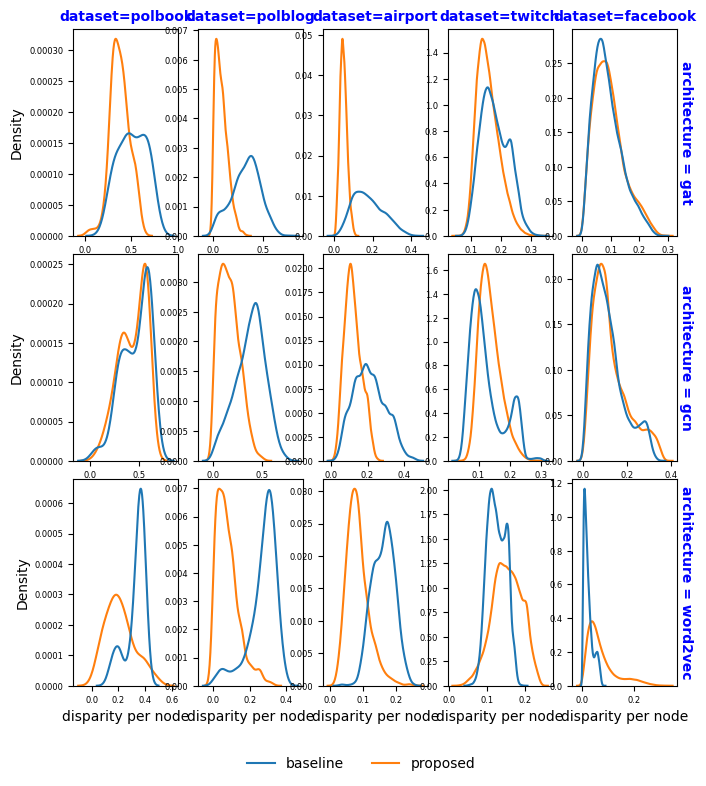

In [9]:
g = sns.displot(data=df, x="disparity per node", kind='kde', hue='model', col="dataset", 
                row='architecture',
                facet_kws=dict(sharey=False, sharex=False, margin_titles=True, despine=False))
# g.fig.set_size_inches(6, 10)
g.fig.set_size_inches(7, 7)
g.set_titles(col_template="dataset={col_name}", fontweight='bold', color="blue")
for (i,j,k), data in g.facet_data():
    ax = g.facet_axis(i, j)
#     ax.set_yticks([])
#     ax.set_xticks([])
    ax.tick_params(axis='both', which='major', labelsize=6)
    ax.tick_params(axis='both', which='minor', labelsize=4)
#     ax.set_title(str(i) + '_' + str(j))
# sns.move_legend(g, "bottom", bbox_to_anchor=(.55, .45), frameon=False)
sns.move_legend(g, "lower center", bbox_to_anchor=(.45, -0.1), ncol=2)
g.legend.set_title(None)

In [15]:
mp = {
    'dataset': [],
    'architecture': [],
    'score': []
}
for dataset in ['polbook', 'polblog', 'airport', 'twitch', 'facebook']:
    for arch in ['gat', 'gcn', 'word2vec']:
        baseline_scores = df[(df.architecture == arch) & (df.model == 'baseline') & (df.dataset == dataset)]['disparity per node'].values
        proposed_scores = df[(df.architecture == arch) & (df.model == 'proposed') & (df.dataset == dataset)]['disparity per node'].values
        
        score = ((baseline_scores - proposed_scores) > 0).sum() / baseline_scores.shape[0]
        mp['dataset'].append(dataset)
        mp['architecture'].append(arch)
        mp['score'].append(score)
        

In [16]:
fdf = pd.DataFrame(mp)

[Text(0, 0.5, 'ratio of nodes for which std dev of disparity decreased')]

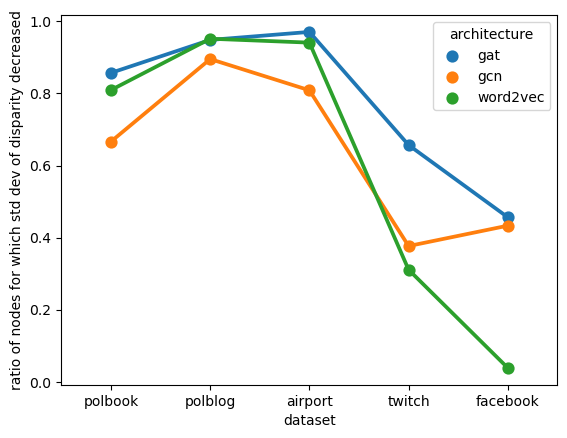

In [19]:
ax = sns.pointplot(data=fdf, x='dataset', y='score', hue='architecture')
ax.set(ylabel='ratio of nodes for which std dev of disparity decreased')